<a href="https://colab.research.google.com/github/Jdasanja/mirrored-dataset/blob/main/Project_2_revised_7_7_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import sklearn as sk
import seaborn as sns

In [3]:
!pip install pyreadstat

Step 1: Load your Data

In [4]:
import pandas as pd

# Load the dataset
url = 'https://github.com/Jdasanja/mirrored-dataset/blob/main/fram_heart_study.csv?raw=true'
df = pd.read_csv(url)

# Add a unique identifier column
df['patient_id'] = range(1, len(df) + 1)

# Set 'patient_id' as the index
df.set_index('patient_id', inplace=True)

print(df.head(5))

            male  age  education  currentSmoker  cigsPerDay  BPMeds  \
patient_id                                                            
1              1   39        4.0              0         0.0     0.0   
2              0   46        2.0              0         0.0     0.0   
3              1   48        1.0              1        20.0     0.0   
4              0   61        3.0              1        30.0     0.0   
5              0   46        3.0              1        23.0     0.0   

            prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP  \
patient_id                                                                   
1                         0             0         0    195.0  106.0   70.0   
2                         0             0         0    250.0  121.0   81.0   
3                         0             0         0    245.0  127.5   80.0   
4                         0             1         0    225.0  150.0   95.0   
5                         0       

Step 2: (If not already done in Project 1) Prepare your data

In [5]:
from sklearn.utils import resample
target_column = 'TenYearCHD'
# Upsampling the minority class
data_majority = df[df[target_column] == 0]
data_minority = df[df[target_column] == 1]
data_minority_upsampled = resample(data_minority, replace=True, n_samples=len(data_majority), random_state=123)
df_upsampled = pd.concat([data_majority, data_minority_upsampled])

In [6]:
from sklearn.model_selection import train_test_split
# Define the features and target
# Drop the unique identifier and the target column from features
X = df_upsampled.drop(columns=['TenYearCHD'])

# Separate the target
y = df_upsampled['TenYearCHD']

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Now, X_train and X_test contain only relevant feature columns
# y_train and y_test contain only the target variable

In [7]:
from sklearn.impute import SimpleImputer

# Handling missing values using imputation strategies
mean_imputer = SimpleImputer(strategy='mean')
mean_cols = ['heartRate']
X_train[mean_cols] = mean_imputer.fit_transform(X_train[mean_cols])
X_test[mean_cols] = mean_imputer.transform(X_test[mean_cols])

median_imputer = SimpleImputer(strategy='median')
median_cols = ['education', 'cigsPerDay', 'BPMeds', 'totChol', 'BMI', 'glucose']
X_train[median_cols] = median_imputer.fit_transform(X_train[median_cols])
X_test[median_cols] = median_imputer.transform(X_test[median_cols])

# Verify no missing values are present
print(X_train.isnull().sum())
print(X_test.isnull().sum())

# Handling outliers using the IQR method
def handle_outliers_with_IQR(X_train, column):
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_train[column] = X_train[column].clip(lower=lower_bound, upper=upper_bound)

continuous_cols = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
for col in continuous_cols:
    handle_outliers_with_IQR(X_train, col)

# Handling outliers using the IQR method
def handle_outliers_with_IQR(X_test, column):
    Q1 = X_test[column].quantile(0.25)
    Q3 = X_test[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_test[column] = X_test[column].clip(lower=lower_bound, upper=upper_bound)

continuous_cols = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
for col in continuous_cols:
    handle_outliers_with_IQR(X_test, col)

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
dtype: int64
male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
dtype: int64


Step 3: Examine your target attribute.

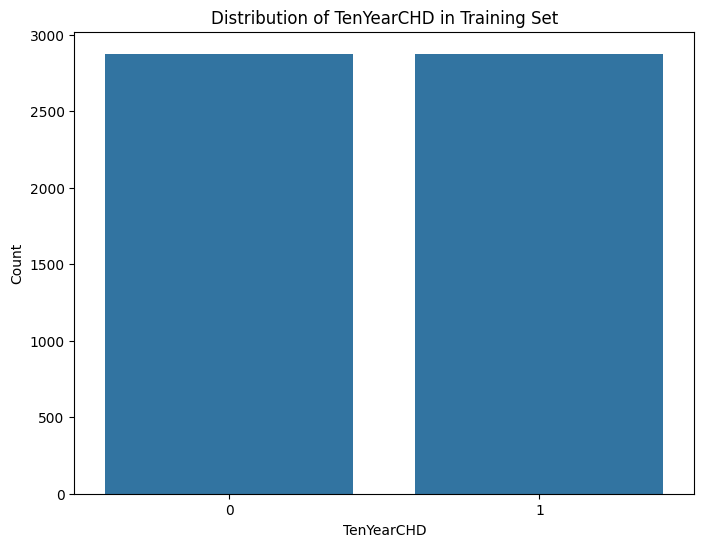

In [8]:
# Checking if the data is imbalanced

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target attribute
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title('Distribution of TenYearCHD in Training Set')
plt.xlabel('TenYearCHD')
plt.ylabel('Count')
plt.show()

Step 4: Selected two of the following supervised learning algorithms, ideally one from the first half of the list and one from the second half of the list

In [9]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import OneHotEncoder

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.columns] = np.log1p(X_copy[self.columns])
        return X_copy
# Define the columns to apply logarithmic transformation
log_transform_columns = ['sysBP', 'diaBP']

# Define the preprocessing pipeline
ct = ColumnTransformer(
    transformers=[
        ("log_transform", LogTransformer(log_transform_columns), log_transform_columns),
        ("scaling", StandardScaler(), ['age','cigsPerDay','totChol','sysBP','diaBP','BMI','heartRate','glucose']),
        ("onehot", OneHotEncoder(sparse_output=False), ['BPMeds', 'education', 'male','diabetes','currentSmoker','prevalentStroke','prevalentHyp'])
    ],
    remainder='drop'  # drop all other columns not specified
)

# Apply the transformations
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [10]:
!pip install imblearn

Accuracy: 0.5941626129256428
F1 Score: 0.6257223814966127
Precision: 0.7382213492409445
Recall: 0.5941626129256428


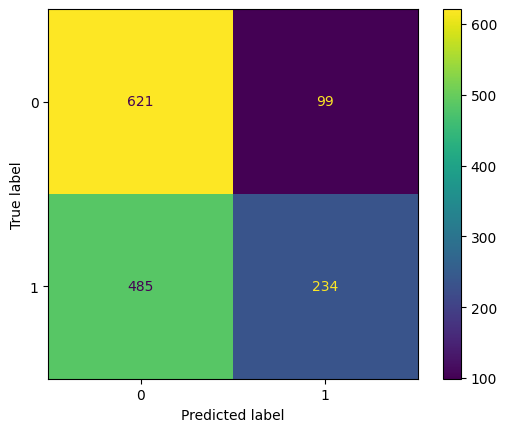

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler

# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)


# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")
precision = precision_score(y_pred, y_test, average="weighted")
recall = recall_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
cmd.plot()

Accuracy of the model: 0.8763029881862404
F1 Score of the model: 0.8760461959250017
Precision: 0.8805023352705592
Recall: 0.8763029881862404


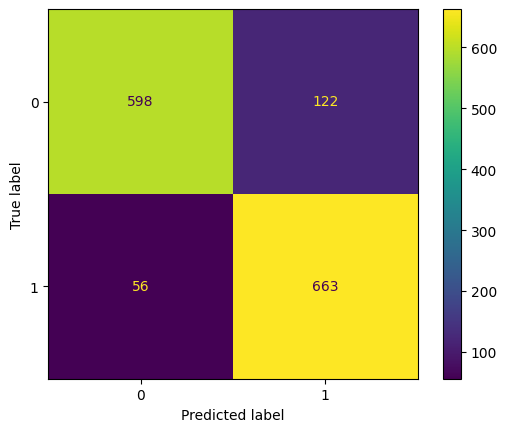

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,precision_score, recall_score
import matplotlib.pyplot as plt

# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42,max_depth=10)

# Training the model on the training dataset
clf.fit(X_train, y_train)

# Performing predictions on the test dataset
y_pred = clf.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_pred, y_test, average="weighted")
recall = recall_score(y_pred, y_test, average="weighted")

# Print accuracy and F1 score
print(f"Accuracy of the model: {accuracy}")
print(f"F1 Score of the model: {f1}")
print("Precision:", precision)
print("Recall:", recall)


# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
cmd.plot()
plt.show()

In [13]:
# Import the necessary library
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42)

# Train the model
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.9145239749826268
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       720
           1       0.87      0.97      0.92       719

    accuracy                           0.91      1439
   macro avg       0.92      0.91      0.91      1439
weighted avg       0.92      0.91      0.91      1439



<li> Step 5: For each of your selected models:
<ul>Run with the default parameters using <b>cross-validation</b> on the whole dataset.</ul>
<ul>Calculate precision, recall, and F1</ul>
<ul>(Where possible) adjust 2-3 parameters for each model using grid search
Report evaluation metrics for the best and worst-performing parameter settings</ul>
</li>

Random Forrest Classifier: K-means Crossfold Validation Training Data

In [14]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cross_val_results = cross_val_score(clf, X_train, y_train, cv=kf)

print(f'Cross-Validation Results (Accuracy): {cross_val_results}')
print(f'Mean Accuracy: {cross_val_results.mean()}')
# Custom scoring functions
precision = cross_val_score(clf, X_train, y_train, cv=kf, scoring=make_scorer(precision_score, average='binary'))
recall = cross_val_score(clf, X_train, y_train, cv=kf, scoring=make_scorer(recall_score, average='binary'))
f1 = cross_val_score(clf, X_train, y_train, cv=kf, scoring=make_scorer(f1_score, average='binary'))

# Print the results
print(f'Cross-Validation Results (Precision): {precision}')
print(f'Mean Precision: {precision.mean()}')

print(f'Cross-Validation Results (Recall): {recall}')
print(f'Mean Recall: {recall.mean()}')

print(f'Cross-Validation Results (F1 Score): {f1}')
print(f'Mean F1 Score: {f1.mean()}')

Cross-Validation Results (Accuracy): [0.8748914  0.85838401 0.85317116 0.86       0.86695652]
Mean Accuracy: 0.8626806179881388
Cross-Validation Results (Precision): [0.8392283  0.83627608 0.81903276 0.83028286 0.84920635]
Mean Precision: 0.8348052703401342
Cross-Validation Results (Recall): [0.92226148 0.895189   0.9083045  0.89426523 0.90219224]
Mean Recall: 0.9044424923226451
Cross-Validation Results (F1 Score): [0.87878788 0.86473029 0.86136177 0.86108714 0.87489779]
Mean F1 Score: 0.8681729755184483


Random Forrest Classifier: K-means Crossfold Validation Testing Data

In [23]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.metrics import make_scorer

clf_model = clf.fit(X_train, y_train)
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cross_val_results_test = cross_val_score(clf_model, X_test, y_test, cv=kf)

print(f'Cross-Validation Results (Accuracy): {cross_val_results_test}')
print(f'Mean Accuracy: {cross_val_results_test.mean()}')
# Custom scoring functions
precision_test = cross_val_score(clf_model, X_test, y_test, cv=kf, scoring=make_scorer(precision_score, average='binary'))
recall_test = cross_val_score(clf_model, X_test, y_test, cv=kf, scoring=make_scorer(recall_score, average='binary'))
f1_test = cross_val_score(clf_model, X_test, y_test, cv=kf, scoring=make_scorer(f1_score, average='binary'))

# Print the results
print(f'Cross-Validation Results (Precision): {precision_test}')
print(f'Mean Precision: {precision_test.mean()}')

print(f'Cross-Validation Results (Recall): {recall_test}')
print(f'Mean Recall: {recall_test.mean()}')

print(f'Cross-Validation Results (F1 Score): {f1_test}')
print(f'Mean F1 Score: {f1_test.mean()}')

Cross-Validation Results (Accuracy): [0.76041667 0.76388889 0.69444444 0.74305556 0.73170732]
Mean Accuracy: 0.7387025745257452
Cross-Validation Results (Precision): [0.74172185 0.75903614 0.68794326 0.68292683 0.73202614]
Mean Precision: 0.7207308468706878
Cross-Validation Results (Recall): [0.78873239 0.81818182 0.68794326 0.8358209  0.75675676]
Mean Recall: 0.7774870254477015
Cross-Validation Results (F1 Score): [0.76450512 0.7875     0.68794326 0.75167785 0.74418605]
Mean F1 Score: 0.7471624561451787


XGB Classifier: Kmeans Cross-validation Training Data

In [16]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
num_folds = 5
cross_val_results_xgb_training = cross_val_score(xgb_classifier, X_train, y_train, cv=kf)

print(f'Cross-Validation Results (Accuracy): {cross_val_results_xgb_training}')
print(f'Mean Accuracy: {cross_val_results_xgb_training.mean()}')

# Custom scoring functions
precision_training_xgb = cross_val_score(xgb_classifier, X_train, y_train, cv=kf, scoring=make_scorer(precision_score, average='binary'))
recall_training_xgb = cross_val_score(xgb_classifier, X_train, y_train, cv=kf, scoring=make_scorer(recall_score, average='binary'))
f1_training_xgb = cross_val_score(xgb_classifier, X_train, y_train, cv=kf, scoring=make_scorer(f1_score, average='binary'))

# Print the results
print(f'Cross-Validation Results (Precision): {precision_training_xgb}')
print(f'Mean Precision: {precision_training_xgb.mean()}')

print(f'Cross-Validation Results (Recall): {recall_training_xgb}')
print(f'Mean Recall: {recall_training_xgb.mean()}')

print(f'Cross-Validation Results (F1 Score): {f1_training_xgb}')
print(f'Mean F1 Score: {f1_training_xgb.mean()}')

Cross-Validation Results (Accuracy): [0.91659427 0.90790617 0.90443093 0.91826087 0.9173913 ]
Mean Accuracy: 0.9129167075888642
Cross-Validation Results (Precision): [0.87066246 0.86391437 0.85779817 0.88032787 0.88190184]
Mean Precision: 0.870920941627476
Cross-Validation Results (Recall): [0.97526502 0.97079038 0.97058824 0.96236559 0.96964587]
Mean Recall: 0.9697310181664228
Cross-Validation Results (F1 Score): [0.92       0.91423948 0.91071429 0.91952055 0.92369478]
Mean F1 Score: 0.9176338189953208


XGB Classifier: Kmeans Cross-validation Testing Data

In [24]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
num_folds = 5
xgb_classifier_model = xgb_classifier.fit(X_train, y_train)
cross_val_results_xgb = cross_val_score(xgb_classifier_model, X_test, y_test, cv=kf)

print(f'Cross-Validation Results (Accuracy): {cross_val_results_xgb}')
print(f'Mean Accuracy: {cross_val_results_xgb.mean()}')

# Custom scoring functions
precision_test_xgb = cross_val_score(xgb_classifier_model, X_test, y_test, cv=kf, scoring=make_scorer(precision_score, average='binary'))
recall_test_xgb = cross_val_score(xgb_classifier_model, X_test, y_test, cv=kf, scoring=make_scorer(recall_score, average='binary'))
f1_test_xgb = cross_val_score(xgb_classifier_model, X_test, y_test, cv=kf, scoring=make_scorer(f1_score, average='binary'))

# Print the results
print(f'Cross-Validation Results (Precision): {precision_test_xgb}')
print(f'Mean Precision: {precision_test_xgb.mean()}')

print(f'Cross-Validation Results (Recall): {recall_test_xgb}')
print(f'Mean Recall: {recall_test_xgb.mean()}')

print(f'Cross-Validation Results (F1 Score): {f1_test_xgb}')
print(f'Mean F1 Score: {f1_test_xgb.mean()}')

Cross-Validation Results (Accuracy): [0.74305556 0.77430556 0.73958333 0.74652778 0.75958188]
Mean Accuracy: 0.7526108207510647
Cross-Validation Results (Precision): [0.70481928 0.78343949 0.72916667 0.68047337 0.74534161]
Mean Precision: 0.7286480843817715
Cross-Validation Results (Recall): [0.82394366 0.7987013  0.74468085 0.85820896 0.81081081]
Mean Recall: 0.8072691155543301
Cross-Validation Results (F1 Score): [0.75974026 0.79099678 0.73684211 0.75907591 0.77669903]
Mean F1 Score: 0.7646708172572614


Adjust 2-3 Parameters Using Grid-Search

In [18]:
from sklearn.model_selection import GridSearchCV

In [1]:


# Define the function to get model parameters
def get_model_params(model):
    """
    This function takes a machine learning model as input and returns its parameters.

    Parameters:
    model (estimator): The machine learning model for which to retrieve the parameters.

    Returns:
    dict: A dictionary containing the parameters of the model.
    """
    if hasattr(model, 'get_params'):
        return model.get_params()
    else:
        raise ValueError("The provided model does not have a 'get_params' method.")

# Create a RandomForestClassifier instance
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)

# Get the parameters of the RandomForestClassifier instance
params = get_model_params(clf)
print(params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Random Forrest Classifier: Evaluating Parameters

In [19]:
# Define the parameters to tune, based on the actual parameter result
forest_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

# Initialize the GridSearchCV object

# Initialize GridSearchCV with the classifier and parameters
clf_GridSearchCV = GridSearchCV(clf, forest_params, cv=10, scoring='precision',n_jobs=-1)

# Assume X_train and y_train are already defined
# Fit the model
clf_GridSearchCV.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = clf_GridSearchCV.best_params_
best_score = clf_GridSearchCV.best_score_

print("Best parameters found: ", best_params)
print("Best precision score: ", best_score)

# Retrieve and display the worst parameters and their score
results = clf_GridSearchCV.cv_results_
worst_index = results['mean_test_score'].argmin()
worst_params = results['params'][worst_index]
worst_score = results['mean_test_score'][worst_index]

print("Worst parameters found: ", worst_params)
print("Worst precision score: ", worst_score)

Best parameters found:  {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best precision score:  0.9755078903955485
Worst parameters found:  {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Worst precision score:  0.793134135923452


Random Forrest Classifier: Parameter Tuning on Training Set

In [21]:
clf_hypertune = RandomForestClassifier(n_estimators=50, random_state=42,max_depth=30,max_features='log2',min_samples_split=2)
clf_hypertune_model = clf_hypertune.fit(X_train, y_train)
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cross_val_results = cross_val_score(clf_hypertune, X_train, y_train, cv=kf)

print(f'Cross-Validation Results (Accuracy): {cross_val_results}')
print(f'Mean Accuracy: {cross_val_results.mean()}')
# Custom scoring functions
precision_hypertune = cross_val_score(clf_hypertune, X_train, y_train, cv=kf, scoring=make_scorer(precision_score, average='binary'))
recall_hypertune = cross_val_score(clf_hypertune, X_train, y_train, cv=kf, scoring=make_scorer(recall_score, average='binary'))
f1_hypertune = cross_val_score(clf_hypertune, X_train, y_train, cv=kf, scoring=make_scorer(f1_score, average='binary'))

# Print the results
print(f'Cross-Validation Results (Precision): {precision_hypertune}')
print(f'Mean Precision: {precision_hypertune.mean()}')

print(f'Cross-Validation Results (Recall): {recall_hypertune}')
print(f'Mean Recall: {recall_hypertune.mean()}')

print(f'Cross-Validation Results (F1 Score): {f1_hypertune}')
print(f'Mean F1 Score: {f1_hypertune.mean()}')

Cross-Validation Results (Accuracy): [0.95308427 0.94874023 0.93918332 0.96173913 0.95652174]
Mean Accuracy: 0.9518537377705588
Cross-Validation Results (Precision): [0.93097643 0.9184     0.9057508  0.94310345 0.94146341]
Mean Precision: 0.9279388185216968
Cross-Validation Results (Recall): [0.9770318  0.9862543  0.98096886 0.98028674 0.97639123]
Mean Recall: 0.9801865850328394
Cross-Validation Results (F1 Score): [0.95344828 0.95111848 0.94186047 0.96133568 0.95860927]
Mean F1 Score: 0.9532744329372849


Random Forrest Classifier: Parameter Tuning on Test Set

In [22]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cross_val_results = cross_val_score(clf_hypertune_model, X_test, y_test, cv=kf)

print(f'Cross-Validation Results (Accuracy): {cross_val_results}')
print(f'Mean Accuracy: {cross_val_results.mean()}')
# Custom scoring functions
precision_hypertune = cross_val_score(clf_hypertune_model, X_test, y_test, cv=kf, scoring=make_scorer(precision_score, average='binary'))
recall_hypertune = cross_val_score(clf_hypertune_model, X_test, y_test, cv=kf, scoring=make_scorer(recall_score, average='binary'))
f1_hypertune = cross_val_score(clf_hypertune_model, X_test, y_test, cv=kf, scoring=make_scorer(f1_score, average='binary'))

# Print the results
print(f'Cross-Validation Results (Precision): {precision_hypertune}')
print(f'Mean Precision: {precision_hypertune.mean()}')

print(f'Cross-Validation Results (Recall): {recall_hypertune}')
print(f'Mean Recall: {recall_hypertune.mean()}')

print(f'Cross-Validation Results (F1 Score): {f1_hypertune}')
print(f'Mean F1 Score: {f1_hypertune.mean()}')

Cross-Validation Results (Accuracy): [0.77777778 0.78125    0.69791667 0.76041667 0.73867596]
Mean Accuracy: 0.7512074138598528
Cross-Validation Results (Precision): [0.76       0.79354839 0.70149254 0.70186335 0.73856209]
Mean Precision: 0.7390932739901485
Cross-Validation Results (Recall): [0.8028169  0.7987013  0.66666667 0.84328358 0.76351351]
Mean Recall: 0.7749963924758964
Cross-Validation Results (F1 Score): [0.78082192 0.7961165  0.68363636 0.76610169 0.75083056]
Mean F1 Score: 0.7555014091996518


XGB Classifier: Evaluating Parameters

In [25]:
# Define the function to get model parameters
def get_model_params(model):
    """
    This function takes a machine learning model as input and returns its parameters.

    Parameters:
    model (estimator): The machine learning model for which to retrieve the parameters.

    Returns:
    dict: A dictionary containing the parameters of the model.
    """
    if hasattr(model, 'get_params'):
        return model.get_params()
    else:
        raise ValueError("The provided model does not have a 'get_params' method.")


# Get the parameters of the RandomForestClassifier instance
params = get_model_params(xgb_classifier)
print(params)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [28]:
forest_params = {
    'max_depth': [None,3, 5, 7],
    'learning_rate': [None,0.1, 0.01, 0.001],
    'subsample': [None,0.5, 0.7, 1]
}

# Initialize GridSearchCV with the classifier and parameters
xgb_classifier_GridSearchCV = GridSearchCV(xgb_classifier, forest_params, cv=10, scoring='precision')

# Assume X_train and y_train are already defined
# Fit the model
xgb_classifier_GridSearchCV.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = xgb_classifier_GridSearchCV.best_params_
best_score = xgb_classifier_GridSearchCV.best_score_

print("Best parameters found: ", best_params)
print("Best precision score: ", best_score)

# Retrieve and display the worst parameters and their score
results = xgb_classifier_GridSearchCV.cv_results_
worst_index = results['mean_test_score'].argmin()
worst_params = results['params'][worst_index]
worst_score = results['mean_test_score'][worst_index]

print("Worst parameters found: ", worst_params)
print("Worst precision score: ", worst_score)

Best parameters found:  {'learning_rate': None, 'max_depth': 7, 'subsample': 0.7}
Best precision score:  0.8964595139694488
Worst parameters found:  {'learning_rate': 0.001, 'max_depth': 3, 'subsample': None}
Worst precision score:  0.6517860452946895


XGB Classifer: Parameter Tuning on Training Set

In [31]:
xgb_classifier_hypertune = XGBClassifier(random_state=42,learning_rate=None,max_depth=7, subsample = 0.7)
xgb_classifier_hypertune_model = xgb_classifier_hypertune.fit(X_train, y_train)
cross_val_results_xgb = cross_val_score(xgb_classifier_hypertune_model, X_train, y_train, cv=kf)

print(f'Cross-Validation Results (Accuracy): {cross_val_results_xgb}')
print(f'Mean Accuracy: {cross_val_results_xgb.mean()}')

# Custom scoring functions
precision_train_xgb = cross_val_score(xgb_classifier_hypertune_model, X_train, y_train, cv=kf, scoring=make_scorer(precision_score, average='binary'))
recall_train_xgb = cross_val_score(xgb_classifier_hypertune_model, X_train, y_train, cv=kf, scoring=make_scorer(recall_score, average='binary'))
f1_train_xgb = cross_val_score(xgb_classifier_hypertune_model, X_train, y_train, cv=kf, scoring=make_scorer(f1_score, average='binary'))

# Print the results
print(f'Cross-Validation Results (Precision): {precision_train_xgb}')
print(f'Mean Precision: {precision_train_xgb.mean()}')

print(f'Cross-Validation Results (Recall): {recall_train_xgb}')
print(f'Mean Recall: {recall_train_xgb.mean()}')

print(f'Cross-Validation Results (F1 Score): {f1_train_xgb}')
print(f'Mean F1 Score: {f1_train_xgb.mean()}')

Cross-Validation Results (Accuracy): [0.91225022 0.9200695  0.92441355 0.9226087  0.93304348]
Mean Accuracy: 0.9224770898651456
Cross-Validation Results (Precision): [0.86499215 0.87461774 0.87711214 0.87400319 0.90062112]
Mean Precision: 0.8782692661382463
Cross-Validation Results (Recall): [0.97349823 0.98281787 0.98788927 0.98207885 0.97807757]
Mean Recall: 0.9808723601407658
Cross-Validation Results (F1 Score): [0.91604323 0.92556634 0.92921074 0.92489451 0.93775263]
Mean F1 Score: 0.9266934901687429


XGB Classifer: Parameter Tuning on Test Set

In [30]:
cross_val_results_xgb_test = cross_val_score(xgb_classifier_hypertune_model, X_test, y_test, cv=kf)

print(f'Cross-Validation Results (Accuracy): {cross_val_results_xgb_test}')
print(f'Mean Accuracy: {cross_val_results_xgb_test.mean()}')

# Custom scoring functions
precision_test_xgb = cross_val_score(xgb_classifier_hypertune_model, X_test, y_test, cv=kf, scoring=make_scorer(precision_score, average='binary'))
recall_test_xgb = cross_val_score(xgb_classifier_hypertune_model, X_test, y_test, cv=kf, scoring=make_scorer(recall_score, average='binary'))
f1_test_xgb = cross_val_score(xgb_classifier_hypertune_model, X_test, y_test, cv=kf, scoring=make_scorer(f1_score, average='binary'))

# Print the results
print(f'Cross-Validation Results (Precision): {precision_test_xgb}')
print(f'Mean Precision: {precision_test_xgb.mean()}')

print(f'Cross-Validation Results (Recall): {recall_test_xgb}')
print(f'Mean Recall: {recall_test_xgb.mean()}')

print(f'Cross-Validation Results (F1 Score): {f1_test_xgb}')
print(f'Mean F1 Score: {f1_test_xgb.mean()}')

Cross-Validation Results (Accuracy): [0.74305556 0.76736111 0.75694444 0.71180556 0.74216028]
Mean Accuracy: 0.7442653890824623
Cross-Validation Results (Precision): [0.71518987 0.78064516 0.7414966  0.64912281 0.73417722]
Mean Precision: 0.7241263311109833
Cross-Validation Results (Recall): [0.79577465 0.78571429 0.77304965 0.82835821 0.78378378]
Mean Recall: 0.7933361143461377
Cross-Validation Results (F1 Score): [0.75333333 0.78317152 0.75694444 0.72786885 0.75816993]
Mean F1 Score: 0.7558976171825831
